In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing batch attack results
results_dir = 'batch_attack_results'

# 1. List all summary and per-run CSVs
all_csvs = glob.glob(os.path.join(results_dir, '*.csv'))
all_csvs

['batch_attack_results/librispeech-v2-THE_YOUNG_KID_JUMPED_THE_RUSTY_GATE-1188-133604-0043.csv',
 'batch_attack_results/librispeech-v1-OAK_IS_STRONG_AND_ALSO_GIVES_SHADE-1089-134691-0005.csv',
 'batch_attack_results/an4-v1-OAK_IS_STRONG_AND_ALSO_GIVES_SHADE-5683-32866-0027.csv',
 'batch_attack_results/librispeech-v1-A_YACHT_SLID_AROUND_THE_POINT_INTO_THE_BAY-260-123440-0008.csv',
 'batch_attack_results/ted-v2-OAK_IS_STRONG_AND_ALSO_GIVES_SHADE-1089-134691-0005.csv',
 'batch_attack_results/an4-v1-THE_YOUNG_KID_JUMPED_THE_RUSTY_GATE-1188-133604-0043.csv',
 'batch_attack_results/librispeech-v2-THE_GRASS_CURLED_AROUND_THE_FENCE_POST-5683-32866-0027.csv',
 'batch_attack_results/ted-v2-A_YACHT_SLID_AROUND_THE_POINT_INTO_THE_BAY-4507-16021-0015.csv',
 'batch_attack_results/ted-v1-THE_HARDER_HE_TRIED_THE_LESS_HE_GOT_DONE-1188-133604-0043.csv',
 'batch_attack_results/librispeech-v2-THE_PENNANT_WAVED_WHEN_THE_WIND_BLEW-4507-16021-0015.csv',
 'batch_attack_results/an4-v1-A_POUND_OF_SUGAR_COSTS_MO

In [2]:
# combine all of the per_run_csvs into a single dataframe
dfs = [pd.read_csv(f) for f in all_csvs]
df_all = pd.concat(dfs, ignore_index=True)
print(df_all.head())
print(f"Combined DataFrame shape: {df_all.shape}")

                                        adv_wav_path  \
0  batch_attack_results/librispeech-v2-THE_YOUNG_...   
1  batch_attack_results/librispeech-v1-OAK_IS_STR...   
2  batch_attack_results/an4-v1-OAK_IS_STRONG_AND_...   
3  batch_attack_results/librispeech-v1-A_YACHT_SL...   
4  batch_attack_results/ted-v2-OAK_IS_STRONG_AND_...   

                              input_wav  \
0  processed_sound/1188-133604-0043.wav   
1  processed_sound/1089-134691-0005.wav   
2   processed_sound/5683-32866-0027.wav   
3   processed_sound/260-123440-0008.wav   
4  processed_sound/1089-134691-0005.wav   

                              target_sentence target_model target_version  \
0         THE YOUNG KID JUMPED THE RUSTY GATE  librispeech             v2   
1          OAK IS STRONG AND ALSO GIVES SHADE  librispeech             v1   
2          OAK IS STRONG AND ALSO GIVES SHADE          an4             v1   
3  A YACHT SLID AROUND THE POINT INTO THE BAY  librispeech             v1   
4          OAK IS S

In [4]:
df_all

,adv_wav_path,input_wav,target_sentence,target_model,target_version,ensemble_models,attack_params,target_pred,target_lev_dists,ensemble_lev_dists,target_losses,ensemble_losses,max_db_diff
0,batch_attack_results/librispeech-v2-THE_YOUNG_...,processed_sound/1188-133604-0043.wav,THE YOUNG KID JUMPED THE RUSTY GATE,librispeech,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",Y THE CALISE T YAND NOTHING WORSH CAN A MORTH ...,"[61, 60, 61, 63, 62, 62, 61, 61, 62, 62, 59, 6...","[[35, 37, 40, 36, 33, 35, 37, 36, 38, 31, 35, ...","[55.41061019897461, 52.254188537597656, 48.914...","[[25.230941772460938, 23.348190307617188, 20.6...",0.226576
1,batch_attack_results/librispeech-v1-OAK_IS_STR...,processed_sound/1089-134691-0005.wav,OAK IS STRONG AND ALSO GIVES SHADE,librispeech,v1,"[{""training_set"": ""an4"", ""version"": ""v1""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",WOTS ETHAR AS THE FEE O FIGCTS AND UNDERNEATH ...,"[54, 52, 52, 52, 51, 51, 51, 52, 49, 53, 51, 5...","[[35, 31, 31, 29, 31, 30, 32, 28, 30, 25, 29, ...","[64.4376449584961, 63.64921188354492, 58.68920...","[[15.754006385803223, 14.580208778381348, 13.0...",0.520103
2,batch_attack_results/an4-v1-OAK_IS_STRONG_AND_...,processed_sound/5683-32866-0027.wav,OAK IS STRONG AND ALSO GIVES SHADE,an4,v1,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",ZROL I U R E O R U NI C I,"[27, 27, 27, 28, 26, 27, 27, 27, 27, 27, 27, 2...","[[43, 41, 39, 33, 33, 28, 30, 35, 23, 30, 29, ...","[10.344533920288086, 10.17883014678955, 10.209...","[[50.755069732666016, 38.43196105957031, 28.41...",0.583246
3,batch_attack_results/librispeech-v1-A_YACHT_SL...,processed_sound/260-123440-0008.wav,A YACHT SLID AROUND THE POINT INTO THE BAY,librispeech,v1,"[{""training_set"": ""an4"", ""version"": ""v1""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",OH WHOM IF I KMILE ALR WE THINK I YOUTH TYE NART,"[34, 33, 30, 31, 31, 30, 30, 29, 31, 32, 30, 3...","[[31, 31, 31, 30, 29, 30, 28, 27, 26, 27, 26, ...","[34.33823776245117, 32.85306167602539, 29.6435...","[[9.219427108764648, 8.82038402557373, 8.45064...",0.188882
4,batch_attack_results/ted-v2-OAK_IS_STRONG_AND_...,processed_sound/1089-134691-0005.wav,OAK IS STRONG AND ALSO GIVES SHADE,ted,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",MET ARE ENI MGER OVER AK G,"[59, 55, 54, 55, 60, 56, 57, 61, 56, 57, 61, 5...","[[32, 32, 31, 30, 28, 26, 33, 26, 27, 24, 25, ...","[56.658206939697266, 53.07245635986328, 48.371...","[[22.996170043945312, 17.986404418945312, 13.3...",0.599577
5,batch_attack_results/an4-v1-THE_YOUNG_KID_JUMP...,processed_sound/1188-133604-0043.wav,THE YOUNG KID JUMPED THE RUSTY GATE,an4,v1,"[{""training_set"": ""librispeech"", ""version"": ""v...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",C A Y E L U V FIVE VI T FI FI,"[31, 32, 31, 31, 31, 30, 30, 31, 31, 31, 31, 3...","[[53, 50, 51, 46, 50, 40, 43, 42, 38, 35, 34, ...","[14.445789337158203, 14.49025821685791, 14.450...","[[60.54767608642578, 43.79960250854492, 37.029...",0.234251
6,batch_attack_results/librispeech-v2-THE_GRASS_...,processed_sound/5683-32866-0027.wav,THE GRASS CURLED AROUND THE FENCE POST,librispeech,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.001, ""PGD_iter"": ...",ONMLY SILY LERYOU JHA LIKE ENDLSRINOI,"[53, 51, 54, 56, 54, 52, 55, 52, 54, 56, 55, 5...","[[32, 34, 37, 33, 34, 33, 31, 28, 30, 29, 26, ...","[49.50707244873047, 42.394195556640625, 45.859...","[[17.021326065063477, 14.858860969543457, 12.2...",0.565536
7,batch_attack_results/ted-v2-A_YACHT_SLID_AROUN...,processed_sound/4507-16021-0015.wav,A YACHT SLID AROUND THE POINT INTO THE BAY,ted,v2,"[{""training_set"": ""an4"", ""version"": ""v2""}, {""t...","{""epsilon"": 0.03, ""alpha"": 0.0

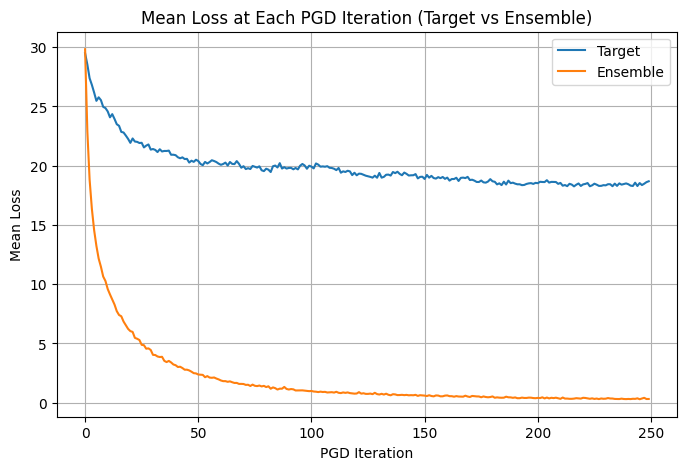

In [58]:
import ast
import numpy as np
import matplotlib.pyplot as plt

# --- Target Loss ---
loss_lists = [ast.literal_eval(x) for x in df_all["target_losses"].dropna()]
max_len = max(len(lst) for lst in loss_lists)
loss_array = np.full((len(loss_lists), max_len), np.nan)
for i, lst in enumerate(loss_lists):
    loss_array[i, :len(lst)] = lst
mean_target_loss = np.nanmean(loss_array, axis=0)

# --- Ensemble Loss ---
ensemble_loss_lists = [ast.literal_eval(x) for x in df_all["ensemble_losses"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_loss_lists)
max_steps = max(len(model) for run in ensemble_loss_lists for model in run)
ens_loss_array = np.full((len(ensemble_loss_lists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_loss_lists):
    for j, model in enumerate(run):
        ens_loss_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_loss = np.nanmean(ens_loss_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(mean_target_loss, label='Target')
plt.plot(mean_ensemble_loss, label='Ensemble')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Loss')
plt.title('Mean Loss at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

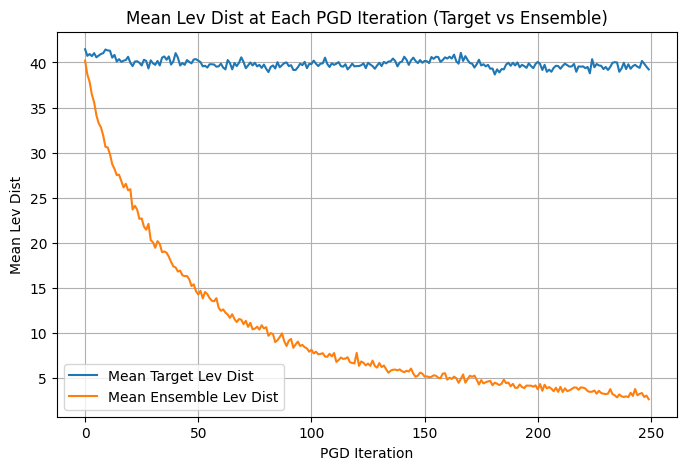

In [ ]:
# --- Target Lev Dist ---
target_lev_dists = [ast.literal_eval(x) for x in df_all["target_lev_dists"].dropna()]
max_len = max(len(lst) for lst in target_lev_dists)
target_lev_array = np.full((len(target_lev_dists), max_len), np.nan)
for i, lst in enumerate(target_lev_dists):
    target_lev_array[i, :len(lst)] = lst
mean_target_lev = np.nanmean(target_lev_array, axis=0)

# --- Ensemble Lev Dist ---
ensemble_lev_dists = [ast.literal_eval(x) for x in df_all["ensemble_lev_dists"].dropna()]
# Flatten to shape: (runs, ensemble_models, steps)
max_ens = max(len(run) for run in ensemble_lev_dists)
max_steps = max(len(model) for run in ensemble_lev_dists for model in run)
ens_lev_array = np.full((len(ensemble_lev_dists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_lev_dists):
    for j, model in enumerate(run):
        ens_lev_array[i, j, :len(model)] = model
# Mean over runs and ensemble models
mean_ensemble_lev = np.nanmean(ens_lev_array, axis=(0,1))

# --- Plot ---
plt.figure(figsize=(8,6))
plt.plot(mean_target_lev, label='Mean Target Lev Dist')
plt.plot(mean_ensemble_lev, label='Mean Ensemble Lev Dist')
plt.xlabel('PGD Iteration')
plt.ylabel('Mean Lev Dist')
plt.title('Mean Lev Dist at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

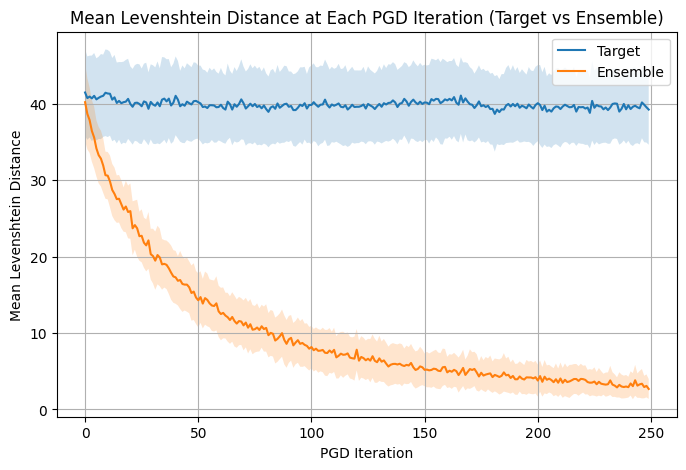

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import ast

# --- Target Lev Dist ---
target_lev_dists = [ast.literal_eval(x) for x in df_all["target_lev_dists"].dropna()]
max_len = max(len(lst) for lst in target_lev_dists)
target_lev_array = np.full((len(target_lev_dists), max_len), np.nan)
for i, lst in enumerate(target_lev_dists):
    target_lev_array[i, :len(lst)] = lst
mean_target_lev = np.nanmean(target_lev_array, axis=0)
std_target_lev = np.nanstd(target_lev_array, axis=0)

# --- Ensemble Lev Dist ---
ensemble_lev_dists = [ast.literal_eval(x) for x in df_all["ensemble_lev_dists"].dropna()]
max_ens = max(len(run) for run in ensemble_lev_dists)
max_steps = max(len(model) for run in ensemble_lev_dists for model in run)
ens_lev_array = np.full((len(ensemble_lev_dists), max_ens, max_steps), np.nan)
for i, run in enumerate(ensemble_lev_dists):
    for j, model in enumerate(run):
        ens_lev_array[i, j, :len(model)] = model
mean_ensemble_lev = np.nanmean(ens_lev_array, axis=(0,1))
std_ensemble_lev = np.nanstd(ens_lev_array, axis=(0,1))

# --- Plot ---
k = 0.5  # Change this factor as desired
x = np.arange(len(mean_target_lev))
x_ens = np.arange(len(mean_ensemble_lev))

plt.figure(figsize=(8,5))
plt.plot(mean_target_lev, label='Target')
plt.fill_between(x, mean_target_lev - k*std_target_lev, mean_target_lev + k*std_target_lev, alpha=0.2)

plt.plot(mean_ensemble_lev, label='Ensemble')
plt.fill_between(x_ens, mean_ensemble_lev - k*std_ensemble_lev, mean_ensemble_lev + k*std_ensemble_lev, alpha=0.2)

plt.xlabel('PGD Iteration')
plt.ylabel('Mean Levenshtein Distance')
plt.title('Mean Levenshtein Distance at Each PGD Iteration (Target vs Ensemble)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# First parse out the average of the last five levenshtein distances for the target
df_all['final_target_lev_dist'] = df_all['target_lev_dists'].apply(lambda x: np.mean(ast.literal_eval(x)[-5:]))

# Histogram of the final target levenshtein distances
df_all['final_target_lev_dist'].hist(bins=50)
plt.show()

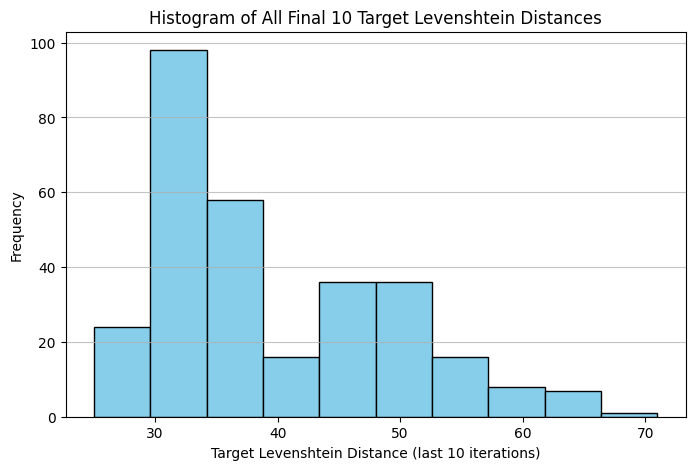

In [27]:
import numpy as np
import ast
import matplotlib.pyplot as plt

# Extract all of the last five Levenshtein distances from each entry
last_five_lev_dists = df_all['target_lev_dists'].apply(lambda x: ast.literal_eval(x)[-10:])
# Flatten the list of lists into a single list
all_last_five = [item for sublist in last_five_lev_dists for item in sublist]

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(all_last_five, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Target Levenshtein Distance (last 10 iterations)')
plt.ylabel('Frequency')
plt.title('Histogram of All Final 10 Target Levenshtein Distances')
plt.grid(axis='y', alpha=0.75)
plt.show()

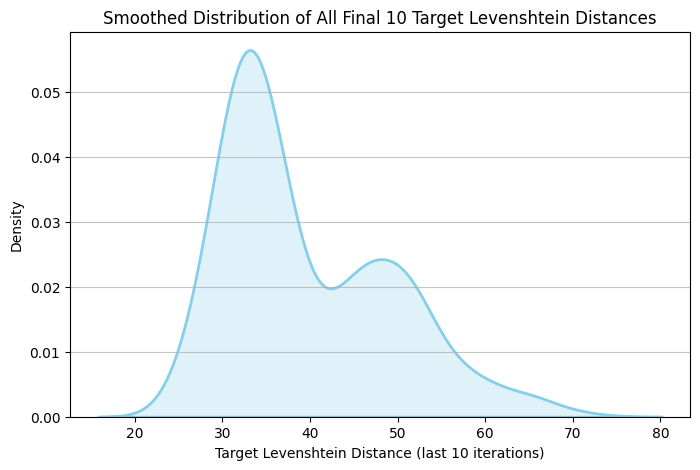

In [33]:
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Extract all of the last ten Levenshtein distances from each entry
last_ten_lev_dists = df_all['target_lev_dists'].apply(lambda x: ast.literal_eval(x)[-10:])
all_last_ten = [item for sublist in last_ten_lev_dists for item in sublist]

plt.figure(figsize=(8, 5))
sns.kdeplot(all_last_ten, fill=True, color='skyblue', linewidth=2)
plt.xlabel('Target Levenshtein Distance (last 10 iterations)')
plt.ylabel('Density')
plt.title('Smoothed Distribution of All Final 10 Target Levenshtein Distances')
plt.grid(axis='y', alpha=0.75)
plt.show()

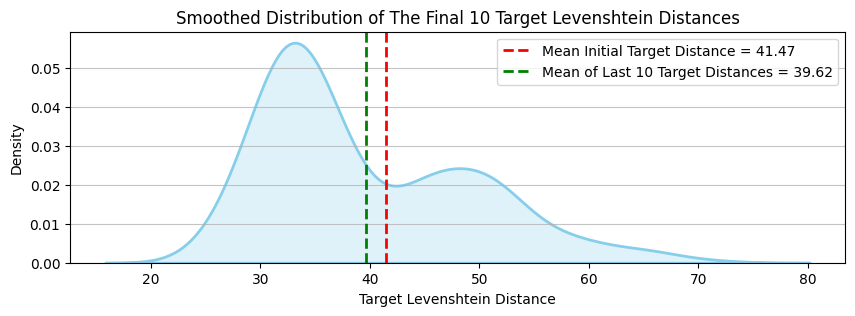

In [55]:
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Extract all of the last ten Levenshtein distances from each entry
last_ten_lev_dists = df_all['target_lev_dists'].apply(lambda x: ast.literal_eval(x)[-10:])
all_last_ten = [item for sublist in last_ten_lev_dists for item in sublist]

# Calculate the mean initial Levenshtein distance (first entry of each sequence)
initial_lev_dists = df_all['target_lev_dists'].apply(lambda x: ast.literal_eval(x)[0])
mean_initial_lev_dist = np.mean(initial_lev_dists)

# Calculate the mean of all last ten Levenshtein distances (across all entries)
mean_last_ten_lev_dist = np.mean(all_last_ten)

plt.figure(figsize=(10, 3))
sns.kdeplot(all_last_ten, fill=True, color='skyblue', linewidth=2)
plt.axvline(mean_initial_lev_dist, color='red', linestyle='--', linewidth=2, label=f'Mean Initial Target Distance = {mean_initial_lev_dist:.2f}')
plt.axvline(mean_last_ten_lev_dist, color='green', linestyle='--', linewidth=2, label=f'Mean of Last 10 Target Distances = {mean_last_ten_lev_dist:.2f}')
plt.xlabel('Target Levenshtein Distance')
plt.ylabel('Density')
plt.title('Smoothed Distribution of The Final 10 Target Levenshtein Distances')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()